# Count Healthy Trees!
## OR: How can we use the Street Tree Census Data to more efficiently plan for the long term health of the urban forest

I celebrated National Day of Civic Hacking on June 4th 2016 by participating in TreesCount! Hackathon hosted by NYC Parks where I analyzed the health of the urban forest to facilitate more efficient disctribution of financial resources across the boroughs. My goal was to gain __actionable insights__ and:

* identify the key indicators of poor health
* forecast which areas in NYC are likely to need more funds in the future

### __To this aim I followed three steps__: 

[1. Data import and exploration](#first-bullet)

[2. Analysis and modeling](#second-bullet)

[4. Conclusions and future directions](#third-bullet)

What drawn me to this project is that the data was collected with help of numerous volunteers during 2015 census. Those volunteers (and NYC Park staff) walked every street in NYC and laboriously recorded the GPS coordinates, species and health indicators of almost 500.000 trees. Isn't it amazing? 

The dataset is available at https://nycopendata.socrata.com, feel free to play with it yourself, it's very well documented.


## 1. Data import and exploration <a class="anchor" id="first-bullet"></a>
List of Python libraries I'm gonna use:

In [28]:
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import patsy
import ml_helper as mlhelp

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [29]:
trees = pd.read_csv("/Users/zuzia/Desktop/Coding/2015_Street_Tree_Census.csv")


How does the data look like?

In [5]:
trees.head()

,FID,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,...,st_assem,st_senate,nta,nta_name,boro_ct,state,latitude,longitude,x_sp,y_sp
0,0,101233,216486,07/29/2015,4,0,OnCurb,Alive,Good,Quercus bicolor,...,50,18,BK76,Greenpoint,3056300,New York,40.735813,-73.958486,995754.8999,207355.7530
1,1,101234,216486,07/29/2015,4,0,OnCurb,Alive,Good,Quercus bicolor,...,50,18,BK76,Greenpoint,3056300,New York,40.735969,-73.958512,995747.6368,207412.7922
2,2,101235,216486,07/29/2015,4,0,OnCurb,Alive,Good,Quercus bicolor,...,50,18,BK76,Greenpoint,3056300,New York,40.736050,-73.958525,995743.8851,207442.2541
3,3,101400,216291,07/29/2015,15,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,50,18,BK76,Greenpoint,3056300,New York,40.735464,-73.958851,995653.7774,207228.7683
4,4,101401,216291,07/29/2015,18,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,50,18,BK76,Greenpoint,3056300,New York,40.735452,-73.958986,995616.2581,207224.1693


Taking a peek at data format:

In [6]:
trees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468341 entries, 0 to 468340
Data columns (total 41 columns):
FID           468341 non-null int64
tree_id       468341 non-null int64
block_id      468341 non-null int64
created_at    468341 non-null object
tree_dbh      468341 non-null int64
stump_diam    468341 non-null int64
curb_loc      468341 non-null object
status        468341 non-null object
health        468341 non-null object
spc_latin     468341 non-null object
spc_common    468341 non-null object
steward       468341 non-null object
guards        468341 non-null object
sidewalk      468341 non-null object
user_type     468341 non-null object
root_stone    468341 non-null object
root_grate    468341 non-null object
root_other    468341 non-null object
trunk_wire    468341 non-null object
trnk_light    468341 non-null object
trnk_other    468341 non-null object
brch_light    468341 non-null object
brch_shoe     468341 non-null object
brch_other    468341 non-null object
addres


Let's see how the distribution of samples looks like around the city 

If you're viewing this on Github the map will not be visible, you need to either download my Jupyter notebook or go to https://zuzanna.carto.com/viz/7317a0b0-d77d-11e6-83c6-0e05a8b3e3d7/public_map to see the map

In [7]:
from IPython.core.display import display, HTML
display(HTML('<iframe width="100%" height="520" frameborder="0" src="https://zuzanna.carto.com/viz/7317a0b0-d77d-11e6-83c6-0e05a8b3e3d7/embed_map" allowfullscreen webkitallowfullscreen mozallowfullscreen oallowfullscreen msallowfullscreen></iframe>'))

Looks like we have a solid coverage across the city, with clear gaps where parks* (e.g. Central Park) or airports are - which is a good sanity check. For now, I'm not looking at the density of the trees in the city, just checking if there are any obvious flaws to the dataset.

*TreesCount dataset includes trees lining the streets of NYC, which excludes NYC Parks. Pretty confusing, but it sort of makes sense - those trees are under different management system.

In the first pass I will use just a subset of features choosing the ones that look like most likely candidates to influence trees health, such as trunk diameter, its health status, location or species.

Some of those variables are on categorical scale, so for the purpose of future analyses I will recode them as such.

In [8]:
trees_=pd.concat([trees.tree_dbh, 
                  trees.status,
                  trees.nta, 
                  trees.steward, 
                  trees.user_type, 
                  trees.spc_common, 
                  trees.borocode, 
                  trees.boroname, 
                  trees.health, 
                  trees.guards, 
                  trees.longitude,
                  trees.latitude], axis=1)

trees_.columns=['diameter',
                'status',
                'neighborhood',
                'stewardship', 
                'user', 
                'species', 
                'boro',
                'boroname',
                'health', 
                'guards', 
                'longitude', 
                'latitude']
trees_['status'] = trees_['status'].astype('category')
trees_['neighborhood'] = trees_['neighborhood'].astype('category')
trees_['stewardship'] = trees_['stewardship'].astype('category')
trees_['user'] = trees_['user'].astype('category')
trees_['species'] = trees_['species'].astype('category')
trees_['boro'] = trees_['boro'].astype('category')
trees_['boroname'] = trees_['boroname'].astype('category')
trees_['health'] = trees_['health'].astype('category')
trees_['guards'] = trees_['guards'].astype('category')


### Exploration: How healthy are the trees in NYC according to the census?

Does it look like someone is taking care of them? Let's look at the values in the 'stewardship' column

How healthy are the trees?

Do trees have guards (tiny fences around them that help to retain moisture)?

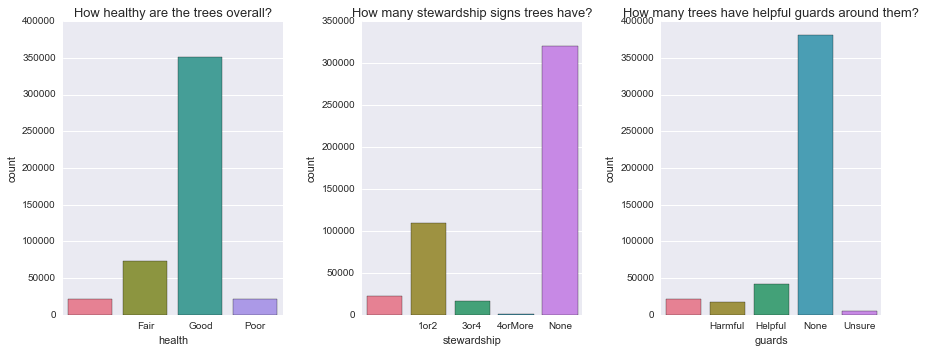

In [9]:
fig = plt.figure(figsize = [13,5])

plt.subplot(1,3,1)
h = sns.countplot(x="health", data=trees_, palette="husl")
plt.title('How healthy are the trees overall?', size=13)
plt.subplot(1,3,2)
f = sns.countplot(x="stewardship", data=trees_, palette="husl")
plt.title('How many stewardship signs trees have?', size=13)
plt.subplot(1,3,3)
g = sns.countplot(x="guards", data=trees_, palette="husl")
plt.title('How many trees have helpful guards around them?', size=13)

plt.tight_layout()
plt.show()

Is there a relationship between stewardship signs and health?

Is there a relationship between guards and health? 

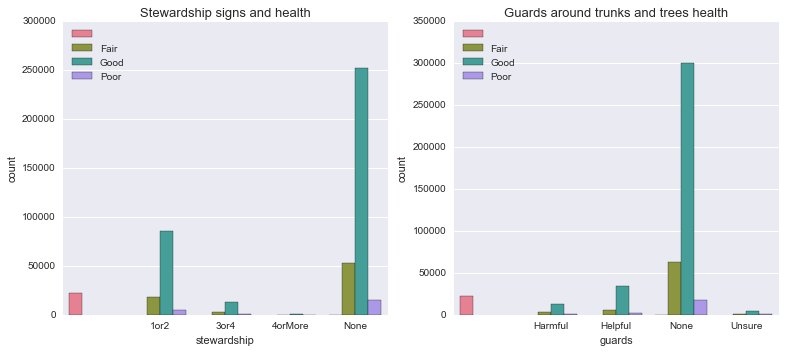

In [10]:
fig = plt.figure(figsize = [11,5])

plt.subplot(1,2,1)
f = sns.countplot(x="stewardship", data=trees_, palette="husl", hue='health')
plt.title('Stewardship signs and health', size=13)
plt.legend(loc=2)
plt.subplot(1,2,2)
h = sns.countplot(x="guards", data=trees_, palette="husl", hue='health')
plt.title('Guards around trunks and trees health', size=13)
plt.legend(loc=2)

plt.tight_layout()
plt.show()

Doesn't seem like it. Just from visual inspection seems like, proportionally, there are more healthy than in "poor condition" trees among those that have no guards whatsoever compared to those that do have (helpful or harmful).

How about trees' diameter? Does it look like there is a difference on any of the above features depending on trees' diameter?

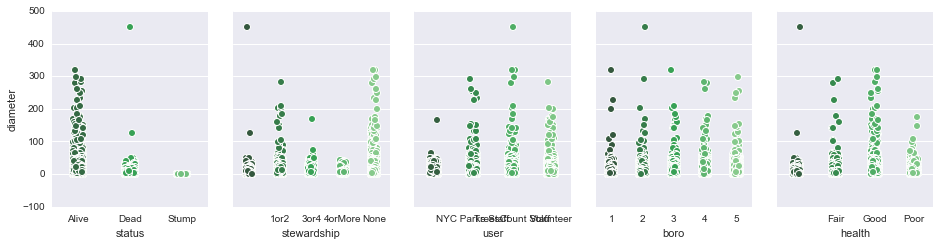

In [11]:
fig = plt.figure(figsize = [11,5])
g = sns.PairGrid(trees_,
                 x_vars=['status','stewardship', 'user', 'boro','health'],
                 y_vars=["diameter"],
                 aspect=.75, size=3.5)
g.map(sns.stripplot, jitter=True, palette="Greens_d");

### Who collects the data? Are volunteers attracted more to certain boroughs?

This is an important question which explores how the community of volunteers was involved in the TreesCount! initiative. I expected that some boroughs, e.g. Manhattan, will be more attractive for volunteers to work (or more volunteers come from these areas).

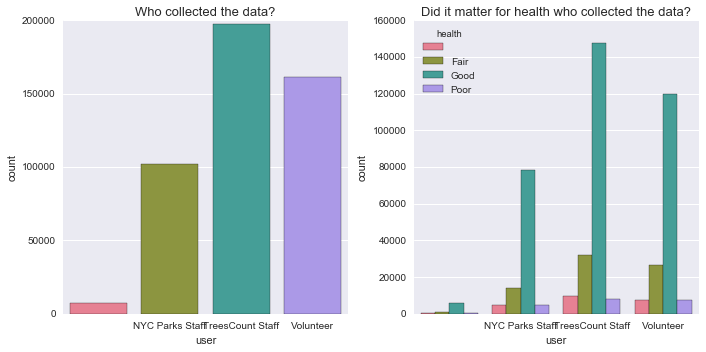

In [12]:
fig = plt.figure(figsize = [10,5])

plt.subplot(1,2,1)
f = sns.countplot(x="user", data=trees_, palette="husl")
plt.title('Who collected the data?', size=13)
plt.subplot(1,2,2)
h = sns.countplot(x="user", data=trees_, palette="husl", hue='health')
plt.title('Did it matter for health who collected the data?', size=13)

plt.tight_layout()
plt.show()

Interesting. Seems like we have a solid number of records entered by volunteers, about half. How does it look across the boroughs?

Looks like Manhattan, Brooklyn and Queens were favored by volunteer teams, with NYC Parks staff & TressCount staff leading the collection in the other boroughs. This came as a big surprise to me - in three out of five boroughs volunteers contributed between 45000 and 50000 entries! In Manhattan the difference is particurarly striking, volunteers entered approximately twice as many samples into the system as staff members. By contrast, in Bronx and Staten Island it was largely by staff efforts that we have a detailed map of the trees. 

I suspected that if we look at the map it will be the farthest neighborhoods from Manhattan that were traversed by the staff. Mapping our data would also allow to quickly look at another variable which plays a role for volunteer programs: seasonality. For civic engagement time of the year definitely matters. For example, if a non-profit is planning an outdoor program, they will most likely avoid doing it in winter. Was it the case with the TreesCount! initiative? 

### Does time of the year matter? 

How did the data collection evolve over time? Are there any seasonal trends? Having data from just one year we can't use any reliable quantitative methods, such as ARIMA, so our observations are purely speculative.

The map below represents data entries within five boroughs recorded by three groups: staff (NYC Parks & TreesCount, in different shades of blue) and volunteers (green). Missing entries are plotted in grey. You can play around by changing the date of the records in the lower left corner.

If you're viewing this on Github the map will not be visible, you need to either download my Jupyter notebook or go to https://zuzanna.carto.com/viz/1583bbc6-d77f-11e6-af25-0e05a8b3e3d7/public_map to view the map

In [13]:
from IPython.core.display import display, HTML
display(HTML('<iframe width="100%" height="520" frameborder="0" src="https://zuzanna.carto.com/viz/1583bbc6-d77f-11e6-af25-0e05a8b3e3d7/embed_map" allowfullscreen webkitallowfullscreen mozallowfullscreen oallowfullscreen msallowfullscreen></iframe>'))

Few observations: 

* The number of data entries, especially from volunteers, seems to be increasing with time. There could be a number of reasons. It could mean that either NYC trained volunteers / distributed the equipment later than they dispatched their own staff or that more volunteers signed up to do the data collection.
* in winter months it is usually the staff who collects the data - volunteers get more excited about being outdoors when it's warmer outside:)
* "null" values are samples from the most recent months, likely haven't been processed yet. Therefore, it would be unwise to get rid of them.

### Are certain species more likely to be unhealthy?

What are different species? What are the most numerous ones?

In [14]:
trees_['species'].value_counts().head()

London Planetree            51890
Honeylocust var. inermis    49199
Callery Pear                45092
Pin Oak                     34555
                            21845
Name: species, dtype: int64

Is there a relationship between species and health? Let's look at a plot of simple counts of trees within each specie that were categorized as "healthy" and those that were described as being in "fair" or "poor" health.

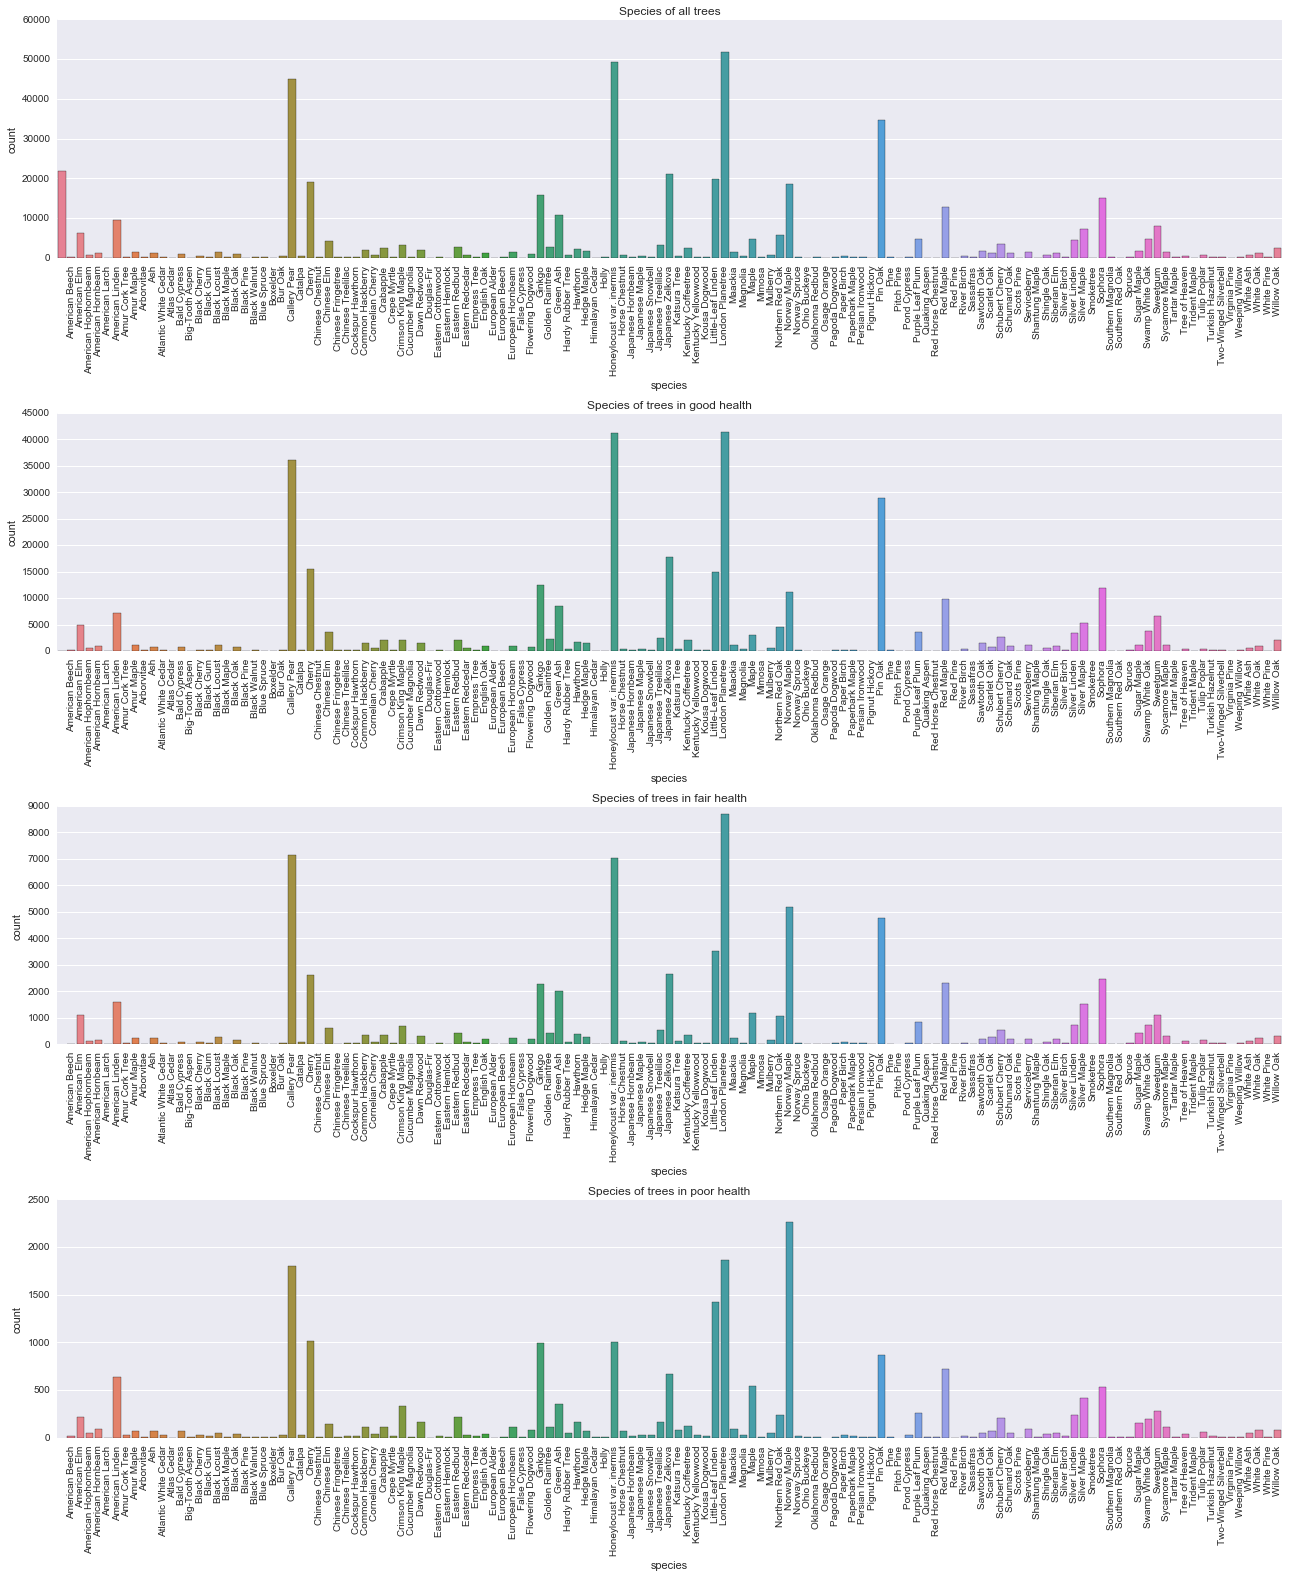

In [15]:
fig = plt.figure(figsize = [18,22])

ax = fig.add_subplot(411, title = 'Species of all trees')
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation = 90,fontsize = 10)
ax1 = fig.add_subplot(412, title = 'Species of trees in good health')
ax1.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation = 90,fontsize = 10)
ax2 = fig.add_subplot(413, title = 'Species of trees in fair health')
ax2.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation = 90,fontsize = 10)
ax3 = fig.add_subplot(414, title = 'Species of trees in poor health')
ax3.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation = 90,fontsize = 10)

f = sns.countplot(ax=ax, x="species", data=trees_, palette="husl")
h = sns.countplot(ax=ax1, x="species", data=trees_[trees_['health'] == 'Good'], palette="husl")
g = sns.countplot(ax=ax2, x="species", data=trees_[trees_['health'] == 'Fair'], palette="husl", )
p = sns.countplot(ax=ax3, x="species", data=trees_[trees_['health'] == 'Poor'], palette="husl", )

plt.tight_layout()
plt.show()

Visual inspection suggests there aren't striking differences between distribution of trees labeled as "healthy" versus "in fair health" (compare second and third plots), however there are some species that seem to be more prone to fall into the unhealthy category. For example, Cherry, Ginkgo or Little Leaf Linden's bars seem to be higher in the third compared to second plot. This might be simply because it's easier to notice the difference in species that are common in the data set (and are subsequently represented with higher bars) or that other species are less likely to be labeled as unhealthy.

For analysis purposes, it will be useful to recode some values (e.g. strings into integers, or multiple classes into binary variable) and clean the dataset (e.g. remove dead trees).

In [16]:
cat_columns = trees_.select_dtypes(['category']).columns
trees_[cat_columns] = trees_[cat_columns].apply(lambda x: x.cat.codes)

#remove tree stumps
trees_ = trees_[trees_.stewardship != 0]
#remove an outlier that has diameter of 40 000 (most likely a typo)
trees_ = trees_[trees_.diameter <100000]

#recode guards variable
recode2={3:0}
trees_['guards'][trees_.guards==3]= trees_['guards'].map(recode2)
recode3={1:0}
trees_['guards'][trees_.guards==1]= trees_['guards'].map(recode3)
recode4={4:0}
trees_['guards'][trees_.guards==4]= trees_['guards'].map(recode4)
recode5={2:1}
trees_['guards'][trees_.guards==2]= trees_['guards'].map(recode5)


There is also the problem of a relatively small number of trees in poor health - around 20 000 out of 450 000. For the purpose of this analysis, I will add them to the trees in "fair" health to avoid __drastic class imbalance__ in the analysis.

In [17]:
#recode fair into poor health
recode0={2:0}
trees_['health'][trees_.health==2]= trees_['health'].map(recode0)
recode1={3:1}
trees_['health'][trees_.health==3]= trees_['health'].map(recode1)

Important thing to remeber is that label "1" means now that a tree is in __*poor*__ health health and "0" that it is in __*good*__ health. I changed it since __*the goal of this analysis is to determine the factors that predict poor health*__. It is an arbitrary decision, of course.

In [18]:
trees_['health'].value_counts()

0    351579
1     94917
Name: health, dtype: int64

Next, I create dummy variables and put them all in one matrix with the variable I want to predict: the health of a tree. Then we're finally ready to run an analysis:)

In [19]:
dummy_ranks_hood = pd.get_dummies(trees_['neighborhood'], prefix='neighborhood')
dummy_ranks_steward = pd.get_dummies(trees_['stewardship'], prefix='stewardship')
dummy_ranks_user = pd.get_dummies(trees_['user'], prefix='user')
dummy_ranks_species = pd.get_dummies(trees_['species'], prefix='species')
dummy_ranks_boro = pd.get_dummies(trees_['boro'], prefix='boro')
dummy_ranks_guards = pd.get_dummies(trees_['guards'], prefix='guards')

X_vec=pd.concat([trees_['diameter'], 
                 dummy_ranks_steward, 
                 dummy_ranks_user, 
                 dummy_ranks_guards, 
                 dummy_ranks_hood, 
                 dummy_ranks_species],1)

X=X_vec
y=trees_['health']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=0)
print X_train.shape
print y_test.shape

(178598, 337)
(267898,)


# 2. Analysis and Modeling <a class="anchor" id="second-bullet"></a>

## Logistic regression

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=0)

In [21]:
logit = LogisticRegression()
logit = logit.fit(X_train, y_train)
logit_test_pred = logit.predict(X_test)
logit_test_score = logit.score(X_test, y_test)

logit_y_prob_test = logit.predict_proba(X_test)
logit_y_prob_train = logit.predict_proba(X_train)
logit_y = logit.predict_proba(X)

fpr_train, tpr_train, _ = metrics.roc_curve(y_train,logit_y_prob_train[:,1])
roc_auc_train = metrics.auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = metrics.roc_curve(y_test,logit_y_prob_test[:,1])
roc_auc_test = metrics.auc(fpr_test, tpr_test)

print"The accuracy of logistic regression is " + str(logit_test_score)
print "Chance level for this data is " + str(y.mean())

The accuracy of logistic regression is 0.787979006935
Chance level for this data is 0.212581971619


### Interpreting the results

The accuracy of our model is 78%, which means that in 78% of the cases we were able to predict the label of the case (healthy tree versus unhealthy one). That sounds good, right? Well, not really. When you take into account that "1" means that a tree is in poor health, you realize we should flip the chance level since it is a proportion of "1s" to "0s". When we do that:

In [22]:
print "Corrected chance level for this data set is " + str(1-y.mean())

Corrected chance level for this data set is 0.787418028381


Not so great anymore, right? When we look at the confusion matrix what's the likely culprit:

In [42]:
target_names = ['healthy trees', 'unhealthy trees']
print (metrics.confusion_matrix(y_test, logit_test_pred))
print (metrics.classification_report(y_test, logit_test_pred, target_names=target_names))

mlhelp.classification_accuracy(logit_test_pred, y_test);

[[209459   1234]
 [ 55566   1639]]
                 precision    recall  f1-score   support

  healthy trees       0.79      0.99      0.88    210693
unhealthy trees       0.57      0.03      0.05     57205

    avg / total       0.74      0.79      0.70    267898

Percentage correct predictions = 78.80
Percentage correct predictions (true class 0) = 79.03
Percentage correct predictions (true class 1) = 57.05


For "1" label recall metric where \begin{equation*}recall = \frac{truepositives}{truepositives + falsepositives}\end{equation*} is merely 3%. It is a pretty terrible result!

As I mentioned before, there is big a class imbalance problem in our data set - only 20% of trees are labeled as in "poor" or "fair" health, which might have a __big__ influence on classification accuracy. Scikit learn actually has a way of dealing with this using class_weight="balanced" parameter. 


## Improving logistic regression model

In [40]:
logitcv = LogisticRegression(class_weight='balanced')
logitcv.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [41]:
logitcv_test_pred = logitcv.predict(X_test)

[[209459   1234]
 [ 55566   1639]]
                 precision    recall  f1-score   support

  healthy trees       0.79      0.99      0.88    210693
unhealthy trees       0.57      0.03      0.05     57205

    avg / total       0.74      0.79      0.70    267898



In [43]:
print (metrics.confusion_matrix(y_test, logitcv_test_pred))
print (metrics.classification_report(y_test, logitcv_test_pred, target_names=target_names))

[[130298  80395]
 [ 23095  34110]]
                 precision    recall  f1-score   support

  healthy trees       0.85      0.62      0.72    210693
unhealthy trees       0.30      0.60      0.40     57205

    avg / total       0.73      0.61      0.65    267898



### __Taking into account class imbalance in the model does not increase our overall accuracy (in fact, it makes it worse) but it increases recall and precision for unhealthy trees (true positives) from 57% and 5% to 60% and 40%, respectively.__

This is great, because our goal here is to predict factors which help us detect unhealthy trees, not increase the average accuracy. See below the analysis with balanced class model parameter introduced.

In [39]:
logit = LogisticRegression(class_weight='balanced')
logit = logit.fit(X_train, y_train)
logit_test_pred = logit.predict(X_test)
logit_test_score = logit.score(X_test, y_test)

logit_y_prob_test = logit.predict_proba(X_test)
logit_y_prob_train = logit.predict_proba(X_train)
logit_y = logit.predict_proba(X)

fpr_train, tpr_train, _ = metrics.roc_curve(y_train,logit_y_prob_train[:,1])
roc_auc_train = metrics.auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = metrics.roc_curve(y_test,logit_y_prob_test[:,1])
roc_auc_test = metrics.auc(fpr_test, tpr_test)

print"The accuracy of logistic regression is " + str(logit_test_score)
print "Chance level for this data is " + str(y.mean())

The accuracy of logistic regression is 0.613696257531
Chance level for this data is 0.212581971619


In [42]:
print (metrics.classification_report(y_test, logit_test_pred))
print (metrics.confusion_matrix(y_test, logit_test_pred))

             precision    recall  f1-score   support

          0       0.85      0.62      0.72    210693
          1       0.30      0.60      0.40     57205

avg / total       0.73      0.61      0.65    267898

[[130298  80395]
 [ 23095  34110]]


In [55]:
from sklearn.linear_model import LogisticRegressionCV
lrcv = LogisticRegressionCV(scoring='roc_auc', class_weight='balanced')
lrcv.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring='roc_auc', solver='lbfgs', tol=0.0001,
           verbose=0)

In [56]:
lrcv.C_

array([ 0.04641589])

In [61]:
#learner = LogisticRegressionCV(class_weight='balanced')
#learner.fit(X_train, y_train)
y_test_predict = lrcv.predict(X_test)
y_test_probs = lrcv.predict_proba(X_test)

mlhelp.classification_accuracy(y_test_predict, y_test);

Percentage correct predictions = 61.48
Percentage correct predictions (true class 0) = 84.94
Percentage correct predictions (true class 1) = 29.85


In [63]:
Xv = {'X_test': X_test, 'X_train': X_train}
yv = {'y_test': y_test, 'y_train': y_train}
metrics = mlhelp.print_cross_validation_metrics(Xv, yv, lrcv)

No cross-validation done on learner
Train roc_auc: 0.65356
Test roc_auc: 0.65161
Summary statistics
           accuracy  f1_score  precision    recall
threshold                                         
0.1        0.213619  0.351908   0.213532  0.999843
0.2        0.217280  0.352590   0.214111  0.998164
0.3        0.266288  0.362000   0.222271  0.974810
0.4        0.422310  0.387789   0.250605  0.856831
0.5        0.614838  0.397557   0.298463  0.595158
0.6        0.742271  0.328689   0.370306  0.295481
0.7        0.783798  0.161090   0.469798  0.097212
0.8        0.787393  0.029445   0.583784  0.015104
0.9        0.786467  0.000000   0.000000  0.000000


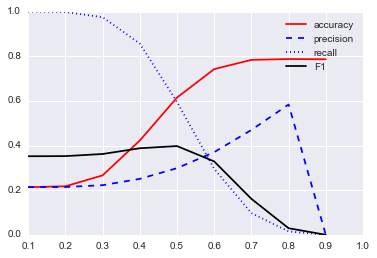

In [64]:
fig = plt.figure()
ax = fig.add_subplot(111)

mlhelp.plot_metrics(metrics, ax)
ax.legend(loc='upper right')

In [70]:
logitcv_test_pred = lrcv.predict(X_test)
print (metrics.classification_report(y_test, logitcv_test_pred))
print (metrics.confusion_matrix(y_test, logitcv_test_pred))

             precision    recall  f1-score   support

          0       0.85      0.62      0.72    210693
          1       0.30      0.60      0.40     57205

avg / total       0.73      0.61      0.65    267898

[[130668  80025]
 [ 23159  34046]]


When we look at the precision value for "1" it is 0.57, which means that we're barely better than chance (0.5) in detecting trees in poor health. Well, always something, I guess?

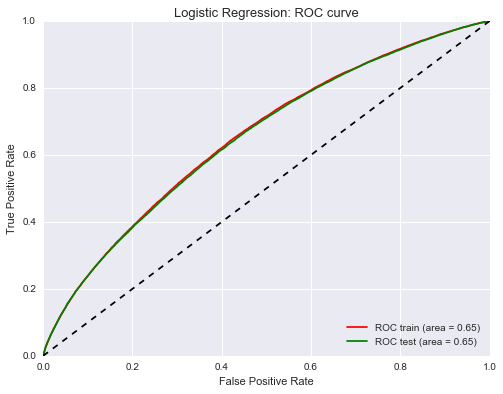

In [41]:
import matplotlib.lines as mlines
plt.figure(figsize=(8,6))
plt.plot(fpr_train, tpr_train, color = 'r')
plt.plot(fpr_test, tpr_test, color = 'g')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression: ROC curve', size = 13)
green_line = mlines.Line2D([], [], color='green', label='ROC test (area = %0.2f)' % np.mean(roc_auc_test))
red_line = mlines.Line2D([], [], color='red', label='ROC train (area = %0.2f)' % roc_auc_train)
plt.legend(handles=[red_line, green_line],loc="lower right")

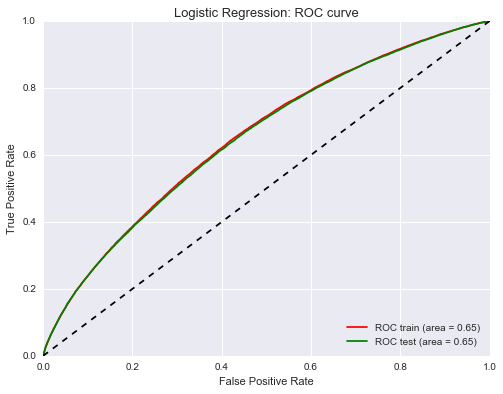

In [43]:
plt.figure(figsize=(8,6))
plt.plot(fpr_train, tpr_train, color = 'r')
plt.plot(fpr_test, tpr_test, color = 'g')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression: ROC curve', size = 13)
green_line = mlines.Line2D([], [], color='green', label='ROC test (area = %0.2f)' % np.mean(roc_auc_test))
red_line = mlines.Line2D([], [], color='red', label='ROC train (area = %0.2f)' % roc_auc_train)
plt.legend(handles=[red_line, green_line],loc="lower right")

Area under the ROC curve for train and test set is identical, so at least our model is equally bad at predicting trees in poor health in the train and test sets (and better than chance, which is the line in the middle).

In [44]:
coeff = pd.DataFrame(zip(X.columns, np.transpose(logit.coef_)))
coeff.columns=['name','value']
newCoeffs = np.array([thisCoef[0] for thisCoef in coeff['value']])
odds = np.exp(newCoeffs)
odds = pd.Series(odds)
odds = pd.Series.to_frame(odds)
odds = odds - 1
odds.columns = ['value']
odds['name'] = coeff['name']

#most healthy
print odds.shape
odds = odds.sort_values('value',ascending=False)
print odds.shape
#odds.sort_values('value',ascending=True)[0:10]
#odds.sort_values('value',ascending=True)[0:10]

(337, 2)
(337, 2)


## Feature importance

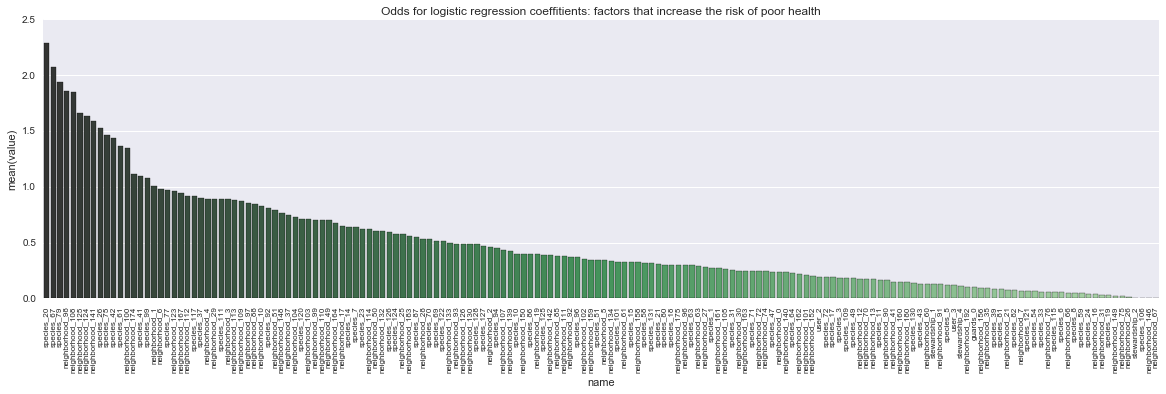

In [45]:
fig = plt.figure(figsize = [20,5])

ax = sns.barplot(x="name", y="value", data=odds[odds['value'] > 0], palette="Greens_d")
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation = 90,fontsize = 8)
ax.set_title('Odds for logistic regression coeffitients: factors that increase the risk of poor health')

#plt.tight_layout()
plt.show()

These are features that are most likely to increase the odds that a tree is in poor health. 

In [48]:
high_odds = odds[odds['value'] > 1]
high_odds.head()

,value,name
224,2.292430,species_20
271,2.075447,species_67
283,1.936437,species_79
109,1.860316,neighborhood_98
119,1.851851,neighborhood_108


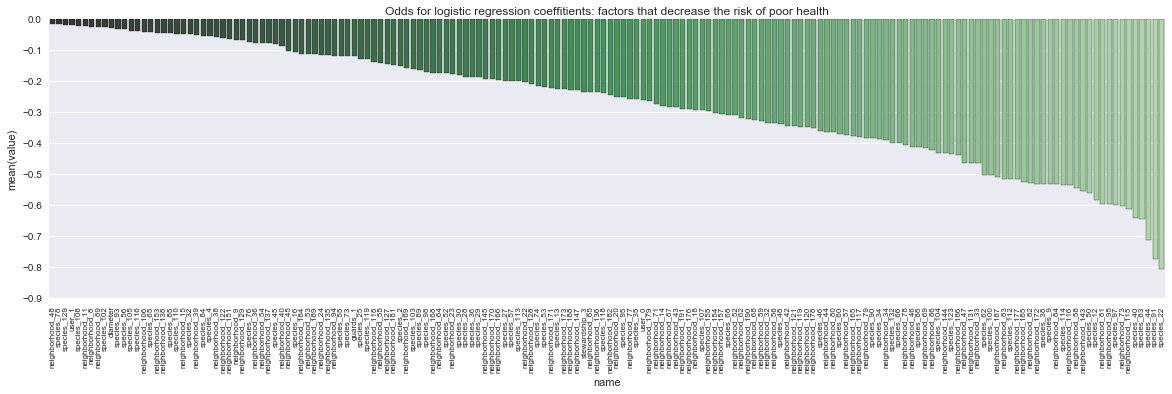

In [49]:
fig = plt.figure(figsize = [20,5])

ax = sns.barplot(x="name", y="value", data=odds[odds['value'] < 0], palette="Greens_d")
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation = 90,fontsize = 8)
ax.set_title('Odds for logistic regression coeffitients: factors that decrease the risk of poor health')

#plt.tight_layout()
plt.show()

In [50]:
low_odds = odds[odds['value'] < -0.6]
low_odds

,value,name
84,-0.601376,neighborhood_73
126,-0.611662,neighborhood_115
244,-0.641746,species_40
287,-0.644005,species_83
248,-0.712485,species_44
295,-0.774386,species_91
226,-0.805497,species_22


In [51]:
y_prob_val = logit.predict_proba(X_vec)

In [52]:
trees_['score_logit'] = y_prob_val[:,1]
trees_.head()

,diameter,status,neighborhood,stewardship,user,species,boro,boroname,health,guards,longitude,latitude,score_logit
0,4,0,36,4,3,118,2,1,0,0,-73.958486,40.735813,0.458637
1,4,0,36,4,3,118,2,1,0,0,-73.958512,40.735969,0.458637
2,4,0,36,4,3,118,2,1,0,0,-73.958525,40.736050,0.458637
3,15,0,36,4,3,60,2,1,0,0,-73.958851,40.735464,0.341573
4,18,0,36,4,3,60,2,1,0,0,-73.958986,40.735452,0.323424


# Analysis and modeling: support vector machine

In [44]:
#SVM
from sklearn.linear_model import SGDClassifier
svm = SGDClassifier()
svm = svm.fit( X_train, y_train )
svm_test_pred = svm.predict(X_test)
svm_test_score = svm.score(X_test, y_test)
print (svm_test_score)

#Classification reports
print (metrics.confusion_matrix(y_test, svm_test_pred))
print (metrics.classification_report(y_test, svm_test_pred))

print "Chance level for this data is " + str(y.mean())
print "Accuracy of SVM is  " + str(1-(svm_test_score))

0.786582953214
[[208580   2113]
 [ 55061   2144]]
             precision    recall  f1-score   support

          0       0.79      0.99      0.88    210693
          1       0.50      0.04      0.07     57205

avg / total       0.73      0.79      0.71    267898

Chance level for this data is 0.212581971619
Accuracy of SVM is  0.213417046786


# Analysis and modeling: random forests

In [39]:
#Random Forest


forest = RandomForestClassifier(n_jobs=-1)
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0)

In [43]:
forest_y_prob_train = forest.predict_proba(X_train)
forest_y_prob_test = forest.predict_proba(X_test)

fpr_train, tpr_train, _ = metrics.roc_curve(y_train,forest_y_prob_train[:,1])
roc_auc_train = metrics.auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = metrics.roc_curve(y_test,forest_y_prob_test[:,1])
roc_auc_test = metrics.auc(fpr_test, tpr_test)

rf_test_score = forest.score(X_test, y_test)

print "Chance level for this data is " + str(y.mean())
print "Accuracy of random forests is " + str(1-(rf_test_score))


Chance level for this data is 0.212581971619
Accuracy of random forests is 0.231502288184


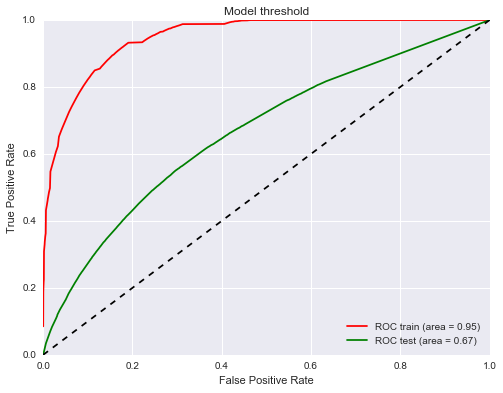

In [45]:
plt.figure(figsize=(8,6))
plt.plot(fpr_train, tpr_train, color = 'r')
plt.plot(fpr_test, tpr_test, color = 'g')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model threshold')
green_line = mlines.Line2D([], [], color='green', label='ROC test (area = %0.2f)' % np.mean(roc_auc_test))
red_line = mlines.Line2D([], [], color='red', label='ROC train (area = %0.2f)' % roc_auc_train)
plt.legend(handles=[red_line, green_line],loc="lower right")

(0.0, 0.6)

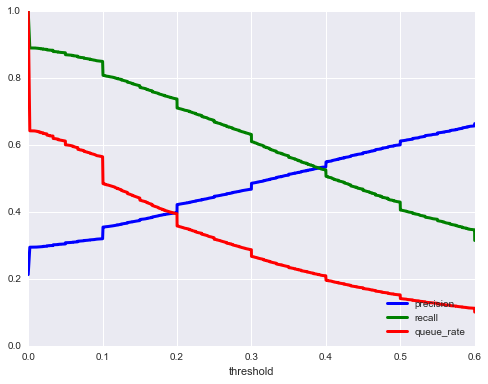

In [46]:
y_prob_val = forest.predict_proba(X)

precision_val, recall_val, thresholds_val = metrics.precision_recall_curve(y,y_prob_val[:,1])

thresholds_val = np.append(thresholds_val, 1)
queue_rate_val = []  
for threshold in thresholds_val:  
    queue_rate_val.append((y_prob_val[:,1] >= threshold).mean())
    
plt.figure(figsize=(8,6))
plt.plot(thresholds_val, precision_val, color = 'b', linewidth=3.0)  
plt.plot(thresholds_val, recall_val, color = 'g', linewidth=3.0)  
plt.plot(thresholds_val, queue_rate_val, color = 'r', linewidth=3.0)
leg = plt.legend(('precision', 'recall', 'queue_rate'),loc="lower right")
plt.xlabel('threshold')
plt.xlim([0.0, 0.6])

Overfitting? Trying grid search with a subsample

In [42]:
import random
from sklearn import grid_search

num = 5000 #number of samples
sub_ind = random.sample(list(X_vec.index),num)
X_vec_10k = X_vec.loc[sub_ind]
y_10k = y.loc[sub_ind]

rf = RandomForestClassifier()
parameters = {'n_estimators': [10,30,100],'max_depth':[10,30],'min_samples_leaf':[5,10,20]}

model_cv_grid = grid_search.GridSearchCV(rf,parameters,scoring='roc_auc',verbose=2,n_jobs=-1)
model_cv_grid.fit(X_vec_10k,y_10k)



Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed: 104.7min remaining: 34.9min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 109.5min finished


[CV] n_estimators=200, max_depth=25, min_samples_leaf=10 .............
[CV] n_estimators=200, max_depth=25, min_samples_leaf=10 .............
[CV] n_estimators=200, max_depth=25, min_samples_leaf=10 .............
[CV] n_estimators=500, max_depth=25, min_samples_leaf=10 .............
[CV] .... n_estimators=200, max_depth=25, min_samples_leaf=10 - 2.5min[CV] .... n_estimators=200, max_depth=25, min_samples_leaf=10 - 2.5min[CV] .... n_estimators=200, max_depth=25, min_samples_leaf=10 - 2.5min[CV] .... n_estimators=500, max_depth=25, min_samples_leaf=10 -90.1min



[CV] n_estimators=500, max_depth=25, min_samples_leaf=10 .............[CV] n_estimators=200, max_depth=25, min_samples_leaf=20 .............[CV] n_estimators=500, max_depth=25, min_samples_leaf=10 .............[CV] n_estimators=200, max_depth=25, min_samples_leaf=20 .............



[CV] .... n_estimators=500, max_depth=25, min_samples_leaf=10 -89.7min[CV] .... n_estimators=200, max_depth=25, min_samples_leaf=20 - 2.2min[CV] ...

GridSearchCV(cv=None,
       estimator=RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid={'n_estimators': [200, 500], 'max_depth': [25, 30], 'min_samples_leaf': [10, 20]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='roc_auc', verbose=2)

In [49]:
model_cv_grid.grid_scores_


NameError: name 'model_cv_grid' is not defined

In [48]:
model_cv_grid.best_estimator_

NameError: name 'model_cv_grid' is not defined

In [45]:
best_model = model_cv_grid.best_estimator_
model_tuned_10k = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0)

TypeError: __init__() got an unexpected keyword argument 'min_weight_fraction_leaf'

In [47]:
#Check over-fitting after Grid Search¶
from sklearn import metrics, cross_validation
X_train_10k, X_test_10k, y_train_10k, y_test_10k = cross_validation.train_test_split(X_vec_10k,y_10k)
model_tuned_10k.fit(X_train_10k,y_train_10k)

NameError: name 'X_vec_10k' is not defined

In [ ]:
y_prob_train_10k = model_tuned_10k.predict_proba(X_train_10k)
y_prob_test_10k = model_tuned_10k.predict_proba(X_test_10k)

fpr_train_10k, tpr_train_10k, _ = metrics.roc_curve(y_train_10k,y_prob_train_10k[:,1])
roc_auc_train_10k = metrics.auc(fpr_train_10k, tpr_train_10k)
fpr_test_10k, tpr_test_10k, _ = metrics.roc_curve(y_test_10k,y_prob_test_10k[:,1])
roc_auc_test_10k = metrics.auc(fpr_test_10k, tpr_test_10k)

plt.figure(figsize=(8,6))
plt.plot(fpr_train_10k, tpr_train_10k, color = 'r')
plt.plot(fpr_test_10k, tpr_test_10k, color = 'g')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC after grid search 100k sample')
green_line = mlines.Line2D([], [], color='green', label='ROC test (area = %0.2f)' % np.mean(roc_auc_test_10k))
red_line = mlines.Line2D([], [], color='red', label='ROC train (area = %0.2f)' % roc_auc_train_10k)
plt.legend(handles=[red_line, green_line],loc="lower right")
plt.savefig('ROC_best_model_10k.pdf')

In [ ]:
print roc_auc_train_10k
print roc_auc_test_10k

What are the most important features from the model?

In [ ]:
df_importance_100k = pd.DataFrame({'variable': X_vec.columns, 'importance' : best_model.feature_importances_})
df_importance_100k.sort_values('importance', ascending=False).head() #save the best estimators for later to plot 

In [ ]:
y_prob = best_model.predict_proba(X_vec)

In [ ]:
plt.figure(figsize=(18, 10))
sns.boxplot(x="species", y="score"
                    ,data=trees_.sort_values(by="species")
                    ,orient='v', width=0.5)

In [ ]:
# Define the grid of hyper-parameters to seach over
grid_search_params = {'n_estimators' : [10, 100, 500],
                      'max_depth' : [2, 5, 10, 20],
                      'min_samples_leaf' : [1, 5, 10, 20]}

learner = RandomForestClassifier(class_weight='balanced')

gs = mlhelp.gridded_cv_fit(X_train, y_train, grid_search_params, learner)

In [ ]:
gs.best_params_

In [ ]:
Xv = {'X_test': X_test, 'X_train': X_train}
yv = {'y_test': y_test, 'y_train': y_train}
metrics = mlhelp.print_cross_validation_metrics(Xv, yv, gs)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

mlhelp.plot_metrics(metrics, ax)
ax.legend(loc='upper right')

In [ ]:
y_test_probs_predict = np.zeros(y_test.shape)
y_test_probs_predict[y_test_probs[:,1]>thresh_best] = 1
mlhelp.classification_accuracy(y_test_probs_predict, y_test);

Save the dataset with new predicting variable

In [ ]:
trees_.to_csv('Desktop/trees_.csv')

# Conclusions and future directions  <a class="anchor" id="third-bullet"></a>

When planting new trees (small diameter) NYC Parks should take into account that: 

* some species are prone to health issues 

* closely monitor their health (small diameter is predictive of health issues)

Also, when planning new outreach activities, NYC Parks should direct them towards neighborhoods where trees' health tends to be worse

General conclusions: 

* logistic regression slightly outperformed SVM and random forests, and the results are much easier to interpret

Future directions, follow-up analyses:

* interactions between species and neighborhoods

* training classifiers on samples collected by NYC Parks staff and testing them on samples collected by volunteers to see if volunteers assess trees' health differently